# Risk Analysis for Coronary Heart Disease

В данной работе я проведу анализ риска возникновения ишемической болезни сердца на основе регрессионной модели данных. При необходимости, я скорректирую модель и выполню предсказание возникновения болезни сердца по имеющимся пациентам.

Для построения модели я использую учебный датасет https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset.

## 1. Предобработка и визуализация данных.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from statsmodels.tools import add_constant
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
df = pd.read_csv('framingham.csv')
df.shape

(4238, 16)

In [3]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


В данных собрана информация о 4328 пациентах и для каждого представлены следующие метрики:
1. male - пол (0 - женский, 1 - мужской);
2. age - возраст;
3. education  - уровень образования (от 1 - высшее образование до 4 - колледж);
4. currentSmoker - является ли пациент курильщиком (0 - нет, 1 - да);
5. cigdPerDay - количество сигарет в день;
6. BPMeds - принимает ли пациент легарства, влияющие на давление (0 - нет, 1 - да);
7. prevalentStroke - инсульт в истории болезни (0 - нет, 1 - да);
8. prevalentHyp - гипертония в истории болезни (0 - нет, 1 - да);
9. diabetes - диабет у пациента (0 - нет, 1 - да);
10. totChol - уровень холестерина (mg/dL);
11. sysBP - систолическое кровяное давление (mmHg);
12. diaBP - диатолическое кровяное давление (mmHg);
13. BMI - индекс массы тела (вес / рост);
14. heartRate - пульс (уд/мин);
15. glucose - уровень глюкозы (mg/dL);
16. TenYearCHD - ишемическая болезнь сердца в истории болезни за последние 10 лет (0 - нет, 1 - да).

In [4]:
df.rename(columns={'male': 'gender_male'}, inplace=True)

Прежде всего необходимо избавится от пропусков.

In [5]:
df.isnull().sum()

gender_male          0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

Пропусков немного, но тем не менее я заменю их на медианные значения каждой переменной в зависимости от пола. 

In [6]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df.query("gender_male == 0")[col].median() if 'male' == 0 \
                                 else df.query("gender_male == 1")[col].median())
df.isnull().sum()

gender_male        0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [7]:
df.describe()

,gender_male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000
mean,0.429212,49.584946,1.979471,0.494101,9.044125,0.029259,0.005899,0.310524,0.025720,236.648183,132.352407,82.893464,25.803276,75.878716,81.603587,0.151958
std,0.495022,8.572160,1.007081,0.500024,11.889515,0.168552,0.076587,0.462763,0.158316,44.331544,22.038097,11.910850,4.070996,12.025185,22.865246,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.080000,68.000000,72.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,233.000000,128.000000,82.000000,25.410000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,262.000000,144.000000,89.875000,28.037500,83.000000,85.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


Построю графики для этих данных. Возможно, некоторые переменные можно исключить из модели еще до ее построения.

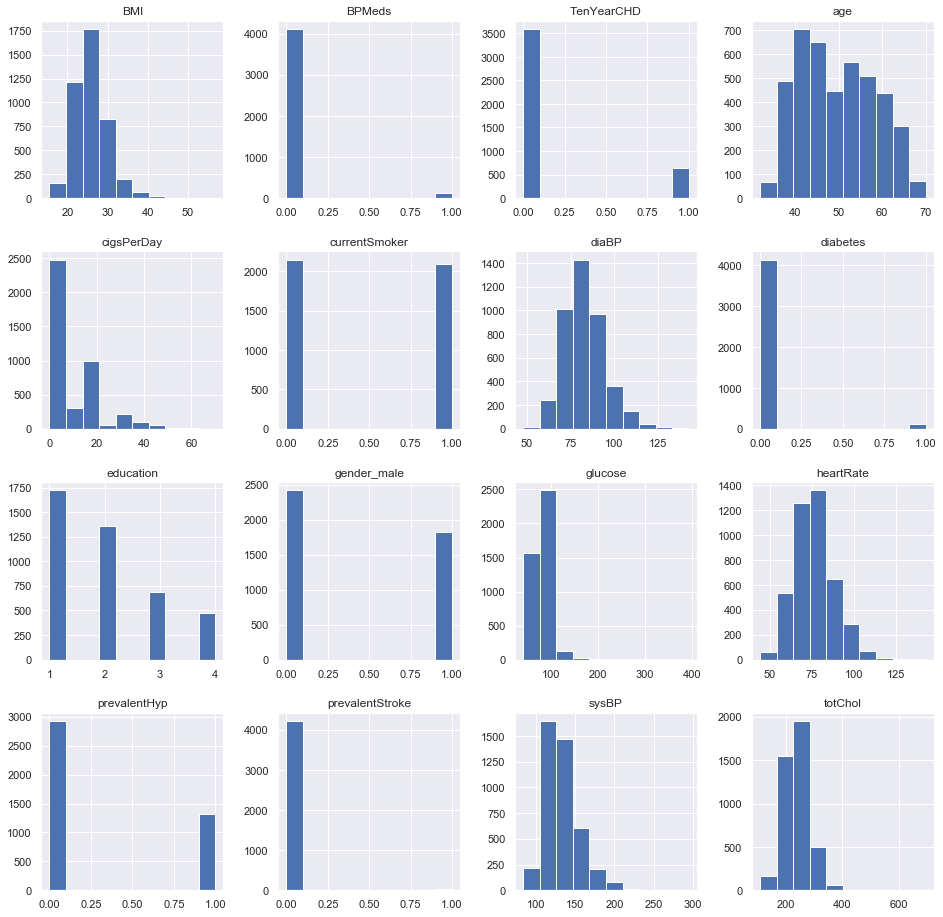

In [9]:
sns.set(style="darkgrid")
df.hist(figsize=(16, 16))
plt.show()

Большая часть количественных переменных имеют длинные "хвосты" справа. Для линейной регрессии это было бы, возможно, критично, но в данном случае отрезать эти значения нет смысла.

Для оценки мультиколлинеарности я построю тепловую карту корреляционной матрицы.

Text(0.5, 1, 'Heatmap of data correlation')

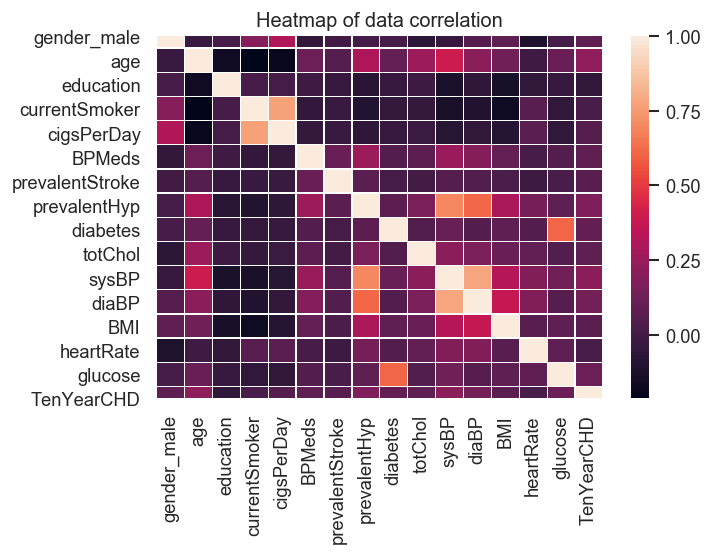

In [10]:
_, axe1 = plt.subplots(dpi=120)
sns.heatmap(df.corr(), ax=axe1, linewidths=.2)
plt.title('Heatmap of data correlation')

Ярко выражена высокая корреляция, что и логично, для пар переменных currentSmoker - cigsPerDay, sysBP - diaBP, prevalentHyp - sysBP. Тем не менее корреляция не превышает 0.75, а значит можно их оставить в модели. Вероятнее всего, эти пары отсеются в следующем шаге.

## 2. Отбор переменных.

Отбор переменных я выполню на основе показателей логит функции пакета stats.model. Предварительно необходимо добавить константу.

In [11]:
df_constant = add_constant(df)
df_constant.head()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,gender_male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,1.0,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1.0,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,1.0,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,1.0,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [12]:
cols = df_constant.columns[:-1]
model = sm.Logit(df.TenYearCHD, df_constant[cols])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.378718
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4238
Model:                          Logit   Df Residuals:                     4222
Method:                           MLE   Df Model:                           15
Date:                Mon, 06 Jan 2020   Pseudo R-squ.:                  0.1112
Time:                        22:41:26   Log-Likelihood:                -1605.0
converged:                       True   LL-Null:                       -1805.8
Covariance Type:            nonrobust   LLR p-value:                 3.296e-76
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.1129      0.665    -12.201      0.000      -9.416      -6.810
gender_male         0.5066      0.100      5.049      0.000       0.310       0.703
age                 0.0620      0.006      9.979      0.000       0.050       0.074
education          -0.0131      0.046     -0.284      0.777      -0.104       0.078
currentSmoker       0.0197      0.145      0.136      0.892      -0.264       0.304
cigsPerDay          0.0208      0.006      3.629      0.000       0.010       0.032
BPMeds              0.2449      0.220      1.112      0.266      -0.187       0.677
prevalentStroke     0.9611      0.442      2.176      0.030       0.095       1.827
prevalentHyp        0.2315      0.128      1.801      0.072      -0.020       0.483
diabetes            0.1915      0.294      0.651      0.515      -0.385       0.768
totChol             0.0018      0.001      1.771      0.077      -0.000       0.004
sysBP               0.0141      0.004      3.991      0.000       0.007       0.021
diaBP              -0.0030      0.006     -0.497      0.619      -0.015       0.009
BMI                 0.0037      0.012      0.310      0.757      -0.019       0.027
heartRate          -0.0015      0.004     -0.381      0.703      -0.009       0.006
glucose             0.0067      0.002      3.117      0.002       0.002       0.011
===================================================================================
"""

Многие переменные посчитаны моделью как статистически незначимымые. Далее я отберу модель с порогом р-уровня значимости всех переменных менее 0.05.

In [13]:
def optimal_features(cols, depend, independ):
    while len(cols) > 0:
        model = sm.Logit(depend, independ[cols])
        result = model.fit(disp = False)
        maxi_p = result.pvalues.nlargest(1)
        if maxi_p[0] < 0.05:
            return(result)
        else:
            cols = cols.drop(maxi_p.index)

In [14]:
result = optimal_features(cols, df.TenYearCHD, df_constant)

In [15]:
result.params, result.prsquared

(const             -8.453711
 gender_male        0.486426
 age                0.064616
 cigsPerDay         0.021236
 prevalentStroke    1.045053
 sysBP              0.017069
 glucose            0.007570
 dtype: float64, 0.10866679586350914)

Функция оставила в модели только значимые переменные: gender_male, age, cigsPerDay, prevalentStroke, sysBP и glucose. Как я и предполагал, кроме незначимых перемнных, отсеялись наиболее коррелирующие между собой переменные.

## 3. Построение модели.

Для модели я разобью данные в пропорции 1 к 4 на тестовые и тренировочные данные. Функцию логистической регрессии возьму из пакета sklearn.

In [16]:
X = df[['gender_male', 'age', 'cigsPerDay', 'prevalentStroke', 'sysBP', 'glucose']]
y = df.TenYearCHD
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

In [17]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
prediction = lr_clf.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
metrics.confusion_matrix(y_test, prediction)

array([[903,   5],
       [144,   8]], dtype=int64)

Матрица ошибок показывает довольно низкое значение false positive при высоком false negative. В перспективе это позволит мне, скорее всего, скорректировать порог отсечки в сторону уменьшения точности.

Для оценки качества модели необходимо рассчитать показатель ROC AUC.

In [19]:
pred_prob = lr_clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob[:, 1])
roc_auc = metrics.roc_auc_score(y_test, pred_prob[:, 1])

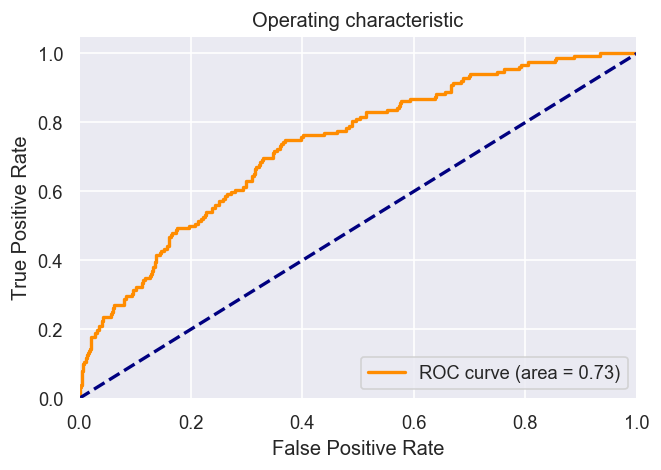

In [20]:
plt.figure(dpi=120)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Operating characteristic')
plt.legend(loc="lower right")

Показатель составляет 0.73, что не так уж хорошо. Поэтому я оценю возможность изменения порога отсечки (по умолчанию 0.5) вероятности положительного исхода. Для этого построю гистограмму распределения частот вероятностей положительного исхода предсказаний модели.

Text(0.5, 1.0, 'Model Prediction Probabilities')

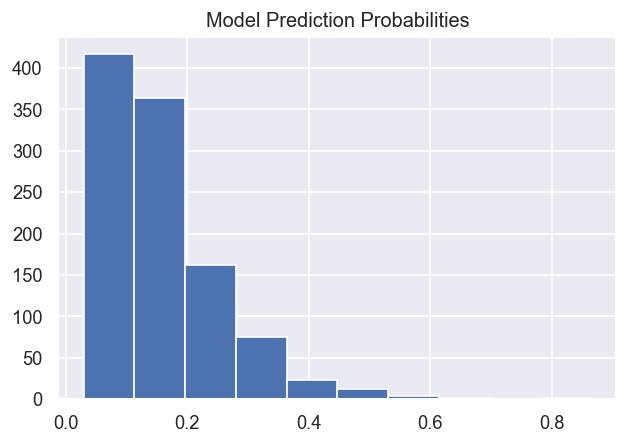

In [21]:
plt.figure(dpi=120)
pd.Series(pred_prob[:, 1]).hist()
plt.title('Model Prediction Probabilities')

Очевидно, что в данных имеется огромный кластер точно предсказанных значений с вероятностью положительного исхода менее 0.2, а значит порог отсечки можно приблизить к этому значению для корректировки предсказаний модели, т.к. очевидно, при предсказании возникновения болезни необходимо уменьшать долю ложноотрицательных ответов.

In [23]:
y_probs = lr_clf.predict_proba(X)[:, 1]
df['predictions'] = np.where(y_probs > 0.5, 1, 0)
metrics.confusion_matrix(df.TenYearCHD, df.predictions)

array([[3583,   11],
       [ 616,   28]], dtype=int64)

Количество ложноотрицательных ответов при стандартной отсечке составляет 616.

In [24]:
df['predictions'] = np.where(y_probs > 0.2, 1, 0)
metrics.confusion_matrix(df.TenYearCHD, df.predictions)

array([[2830,  764],
       [ 310,  334]], dtype=int64)

Корректировка отсечки помогла серьезно уменьшить ошибку предсказаний второго рода, что существенно при анализе рисков возникновения болезни сердца. 

## 4. Оценка на других классификаторах

Далее я сравню эффективность классификатора Random Forest на отобранных переменных, а так же на полных данных. Эмпирическим путем, а так же в ходе экспермиентов с GridSearchCV я определил оптимальные параметры для классификатора и здесь приведу уже результат его работы.

In [25]:
rf_clf = RandomForestClassifier(criterion='entropy', 
                                n_estimators=50, 
                                max_depth=5, 
                                min_samples_split=10, 
                                min_samples_leaf=10)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
predictions2 = rf_clf.predict_proba(X_test)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, predictions2[:, 1])
roc_auc2 = metrics.roc_auc_score(y_test, predictions2[:, 1])

Далее рассчитаю показатели для полных данных.

In [27]:
full_X = df.iloc[:, :15]
full_y = df.TenYearCHD
full_X_train, full_X_test, full_y_train, full_y_test = train_test_split(full_X, full_y, train_size=0.75, random_state=42)
rf_clf.fit(full_X_train, full_y_train)
predictions3 = rf_clf.predict_proba(full_X_test)
fpr3, tpr3, thresholds3 = metrics.roc_curve(full_y_test, predictions3[:, 1])
roc_auc3 = metrics.roc_auc_score(full_y_test, predictions3[:, 1])

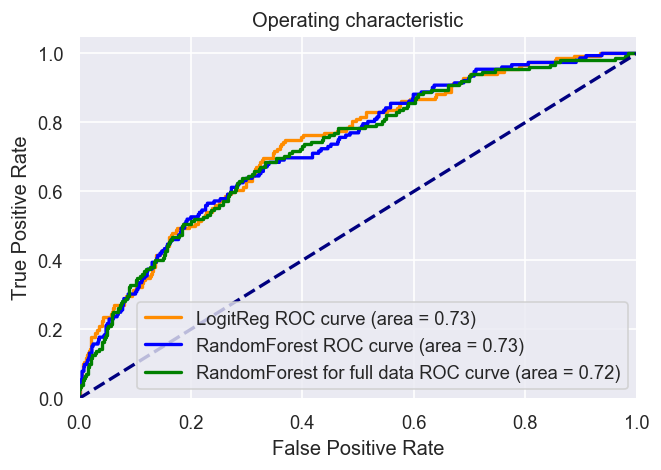

In [28]:
plt.figure(dpi=120)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='LogitReg ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='blue',
         lw=lw, label='RandomForest ROC curve (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='green',
         lw=lw, label='RandomForest for full data ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Operating characteristic')
plt.legend(loc="lower right")

Как видно, применение другого классификатора и использование полных данных не улучшили ситуацию с качеством модели. Показатель ROC AUC примерно одинаков.